# Tutorial 2: An Introduction to the ccdproc package and to image combination

### Further reading:

The ccdproc reference doc:
https://ccdproc.readthedocs.io/

Image reduction cookbook:
https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/index.html


# Load the packages

In [1]:
# Support Posix paths. Takes care of OS specific paths.
from pathlib import Path

# The usual libs
import numpy as np
import matplotlib.pyplot as plt

# Astropy
# The tools in ccdproc accept only CCDData objects
from astropy.nddata import CCDData

from astropy.stats import mad_std
from astropy.modeling import models
from astropy.io import fits

#ccdproc
import ccdproc as ccdp
from ccdproc import ImageFileCollection



# Introducing ImageFileCollection: lists of images in a directory

In [2]:
read_path = Path('0_mainData')
write_path = Path('proc')
write_path.mkdir(exist_ok=True)  # create the directory if it doesn't exist

#Make an image file collection for the raw data
imcol = ImageFileCollection(read_path)  

#imcol.summary.colnames 
#imcol.summary['file']
#imcol.summary['file', 'imagetyp', 'object', 'filter', 'exptime']
#list_flatI = imcol.files_filtered(filter='I', imagetyp='FLAT')
#imcol_flatI = imcol.filter(filter='I', imagetyp='FLAT')

In [3]:
#imcol_flatI.location
imcol.location

PosixPath('0_mainData')

In [4]:
#imcol.summary
imcol.summary['file', 'imagetyp', 'biassec', 'ccdsec', 'datasec']

file,imagetyp,biassec,ccdsec,datasec
str10,str6,str18,str15,str15
3241o.fits,OBJECT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
3249o.fits,OBJECT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
3262o.fits,OBJECT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
3265o.fits,OBJECT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
4015b.fits,BIAS,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
4016b.fits,BIAS,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
4017b.fits,BIAS,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
4075f.fits,FLAT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"
4076f.fits,FLAT,"[1025:1072,1:1024]","[1:1024,1:1024]","[1:1024,1:1024]"


# Subtract overscan and trim 

Note the difference in indexing between the python and fits conventions. Check the "Indexing: python and FITS" section at https://ccdproc.readthedocs.io/en/latest/reduction_toolbox.html#reduction-toolbox


In [7]:
for ccd, file_name in imcol.ccds(ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
    # Subtract the overscan
#    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 1030:1068], median=True)
    #ccd = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', median=True, overscan_axis=1)
    poly_model = models.Polynomial1D(0) ## modelo polinomial de ordem zero que vamos ajustar aos dados (metod. minims quadradros)
    ccd = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', model=poly_model, overscan_axis=1) 
     ##
    # Trim the overscan
#    ccd = ccdp.trim_image(ccd[:, :1024])
    ccd = ccdp.trim_image(ccd, fits_section='[1:1024, 1:1024]')
    
    # Save the result
    ccd.write(str(write_path)+'/OT_'+file_name, overwrite=True)

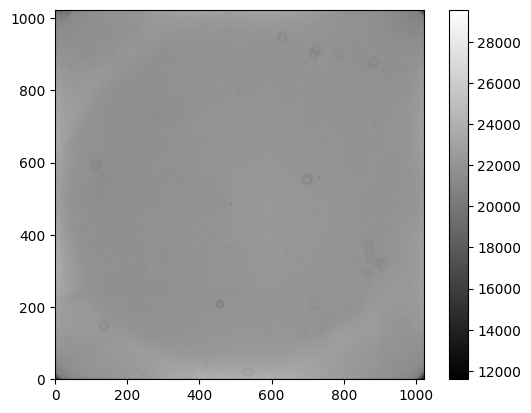

In [8]:
#Show last image
plt.imshow(ccd.data, cmap='gray', origin='lower')
plt.colorbar()

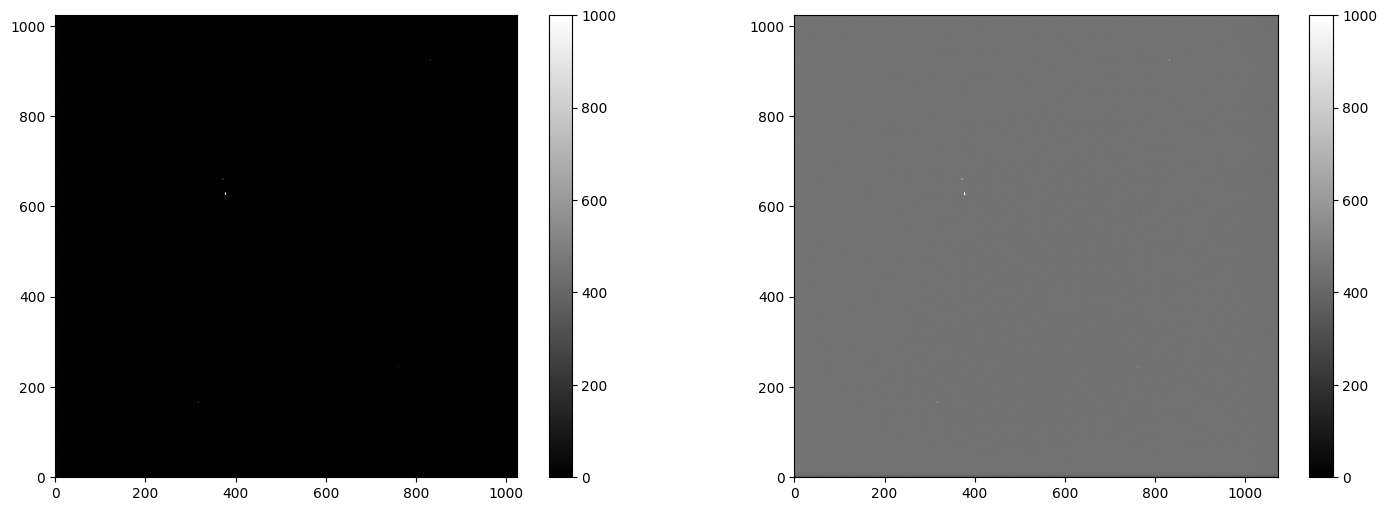

In [10]:
# select one of the bias images you just processed and compare with the raw image
# Use two side-by-side plots analogous to the one above
# Hint: you can create a CCDData object with CCDData.read(path_to_file) and then use the "data" attribute

## Processed data
processed_file = 'OT_4015b.fits'
hdu_list_processed = fits.open(str(write_path)+'/'+processed_file)
processed_data = hdu_list_processed[0].data

## Raw data
raw_file = '4015b.fits'
hdu_list = fits.open(str(read_path)+'/'+raw_file)
raw_data = hdu_list[0].data

#Plot the bias images
nrow=1
ncol=2
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.imshow(processed_data, cmap='gray', vmin=0, vmax=1000, origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,2)
plt.imshow(raw_data, cmap='gray', vmin=0, vmax=1000, origin='lower')
plt.colorbar()

# Combine images: average with rejection

Full documentation on the combine function: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.combine.html#ccdproc.combine

In [14]:
# In this example we'll average combine the bias images we have just processed
reduced_images = ImageFileCollection(write_path, glob_include='OT_*')
#reduced_images.summary['file', 'imagetyp', 'object', 'filter', 'exptime']
list_bias = reduced_images.files_filtered(imagetyp='bias',include_path=True)
list_bias
#reduced_images.files_filtered()

['proc/OT_4015b.fits', 'proc/OT_4016b.fits', 'proc/OT_4017b.fits']

In [15]:
Zero = ccdp.combine(list_bias,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )

Zero.meta['combined'] = True

Zero.write(write_path / 'Zero.fits', overwrite=True)

In [16]:
# Now compare the combined bias with the original. Use a smaller section to avoid edges and spurious high counts
print('Combined:', Zero.data[100:200,100:200].std())

ic_bias = reduced_images.filter(imagetyp='bias')
for ccd in ic_bias.ccds():
    print(ccd.data[100:200,100:200].std())


Combined: 3.0391199521354726


4.779777399628564
4.731325560559113
4.760416997490871


# Subtract the master bias from the object and flat images

In [21]:
# If necessary, rebuild the image collection
reduced_images = ImageFileCollection(write_path, glob_include='OT_*')
# Now select just the the flats and object images
list_OTZ = reduced_images.files_filtered(regex_match=True, imagetyp='object|flat',include_path=True)
list_OTZ

ic_OTZ = reduced_images.filter(regex_match=True, imagetyp='object|flat')


In [24]:
# Lets read the Zero.fits file from disk
Zero = CCDData.read(write_path / 'Zero.fits')
Zero
#OTZ = ccdp.subtract_bias(list_OTZ, Zero)

CCDData([[-76.71482706, -61.04816039, -55.71482706, ..., -78.04816039,
          -76.04816039, -77.4385642 ],
         [-66.71482706, -48.38149372, -42.16316106, ..., -49.54275591,
          -53.38149372, -58.71482706],
         [-43.71482706, -25.04275591, -31.04275591, ..., -31.04816039,
          -32.38149372, -33.71482706],
         ...,
         [ -2.38149372,  13.61850628,  17.95183961, ...,   4.95183961,
           13.28517294,  10.5614358 ],
         [ -6.04816039,  16.61850628,  14.95724409, ...,  10.61850628,
           14.28517294,  10.61850628],
         [ -0.71482706,  18.61850628,  13.95183961, ...,   4.45724409,
           10.28517294,   9.61850628]], unit='adu')

In [25]:

for ccd, file_name in ic_OTZ.ccds(return_fname=True):
    ccd = ccdp.subtract_bias(ccd, Zero)

    ccd.header['zerocor'] = 'Zero.fits'

    # Save the result
    ccd.write(str(write_path)+'/Z'+file_name, overwrite=True)

# **Calcular o ganho e ruído do CCD**

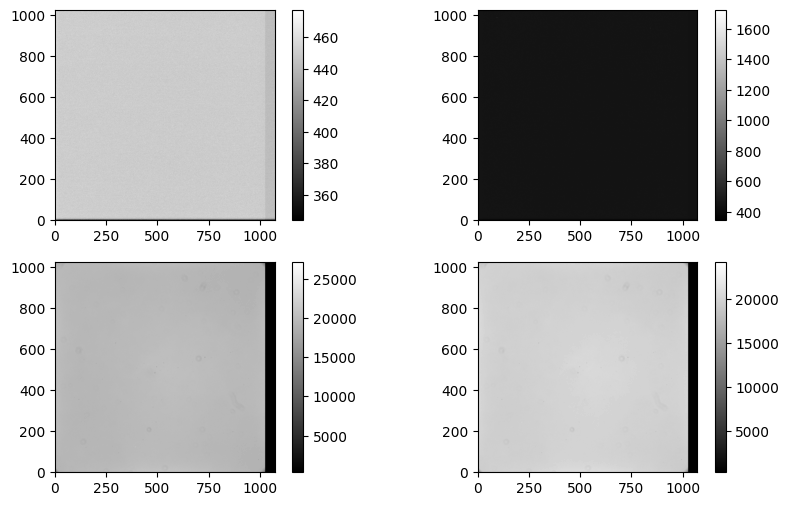

In [26]:
read_path = './gainNoise/'

bias1 = 'bias1.fits'
bias2 = 'bias2.fits'
flat1 = 'domeV1.fits'
flat2 = 'domeV2.fits'

hdu_bias1 = fits.open(read_path+bias1)
hdu_bias2 = fits.open(read_path+bias2)
hdu_flat1 = fits.open(read_path+flat1)
hdu_flat2 = fits.open(read_path+flat2)

data_bias1 = hdu_bias1[0].data
data_bias2 = hdu_bias2[0].data
data_flat1 = hdu_flat1[0].data
data_flat2 = hdu_flat2[0].data

#Plot original images
nrow = 2
ncol = 2
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.imshow(data_bias1, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,2)
plt.imshow(data_bias2, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,3)
plt.imshow(data_flat1, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,4)
plt.imshow(data_flat2, cmap='gray', origin='lower')
plt.colorbar()

In [37]:
write_path = Path('ProcGainNoise')
write_path.mkdir(exist_ok=True)
imcol = ImageFileCollection(read_path)
for ccd, file_name in imcol.ccds(ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
    # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, fits_section='[1030:1068,:]', median=True, overscan_axis=1)
    # Trim the overscan
    ccd = ccdp.trim_image(ccd, fits_section='[10:1020, 10:1020]')
    # Save the result
    ccd.write(str(write_path)+'/OT_'+file_name, overwrite=True)

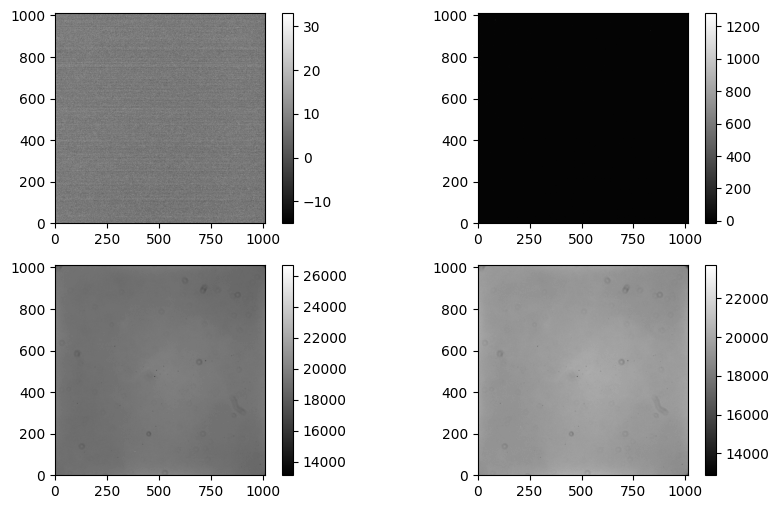

In [38]:
proc_path = './ProcGainNoise/'

bias1 = 'OT_bias1.fits'
bias2 = 'OT_bias2.fits'
flat1 = 'OT_domeV1.fits'
flat2 = 'OT_domeV2.fits'

hdu_bias1 = fits.open(proc_path+bias1)
hdu_bias2 = fits.open(proc_path+bias2)
hdu_flat1 = fits.open(proc_path+flat1)
hdu_flat2 = fits.open(proc_path+flat2)

data_bias1 = hdu_bias1[0].data
data_bias2 = hdu_bias2[0].data
data_flat1 = hdu_flat1[0].data
data_flat2 = hdu_flat2[0].data

#Plot trimmed images
nrow = 2
ncol = 2
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(nrow,ncol,1)
plt.imshow(data_bias1, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,2)
plt.imshow(data_bias2, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,3)
plt.imshow(data_flat1, cmap='gray', origin='lower')
plt.colorbar()
ax = fig.add_subplot(nrow,ncol,4)
plt.imshow(data_flat2, cmap='gray', origin='lower')
plt.colorbar()

In [39]:
proc_imcol = ImageFileCollection(write_path)
for ccd, file_name in proc_imcol.ccds(ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                             # it is not in the header
                                 return_fname=True           # Provide the file name too.
                                ):
    print(ccd.mean())
    #print(file_name) 

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
7.79431691551196 adu
OT_bias1.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
7.73554990064777 adu
OT_bias2.fits
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
19207.62623114093 adu
OT_domeV1.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
19388.97778051718 adu
OT_domeV2.fits


In [41]:
B1_mean = 7.794
B2_mean = 7.735
F1_mean = 19208.
F2_mean = 19389.

b1_2 = data_bias1 - data_bias2
f1_2 = data_flat1 - data_flat2

sigma_b = np.std(b1_2, ddof=1)
sigma_f = np.std(f1_2, ddof=1)

gain = (F1_mean+F2_mean-B1_mean-B2_mean)/(sigma_f**2-sigma_b**2)
print(gain)
read_noise = gain*sigma_b/np.sqrt(2)
print(read_noise)

1.2802072118822552
6.328829190230299
